# FER Transfer on FERG dataset using Norm-reference encoding

The goal is to train the NR mechanism using BFS's Louise and applied to the different heads shapes from the FERG dataset

## import

In [1]:
import os
import numpy as np
import tensorflow as tf

from utils.load_config import load_config
from utils.load_data import load_data
from utils.extraction_model import load_extraction_model
from utils.PatternFeatureReduction import PatternFeatureSelection
from utils.patches import compute_center_of_activity
from models.NormBase import NormBase

%matplotlib inline
import matplotlib.pyplot as plt

np.random.seed(0)
np.set_printoptions(precision=3, suppress=True, linewidth=150)

## Set Parameters

In [16]:
# define configuration
config_path = 'NR_06_FER_transfer_on_FERG_m0002.json'

# load config
config = load_config(config_path, path='../../configs/norm_reference')

# create directory if non existant
save_path = os.path.join("../../models/saved", config["config_name"])
if not os.path.exists(save_path):
    os.mkdir(save_path)

## Load extraction pipeline

In [17]:
# load and define extraction model
v4_model = load_extraction_model(config, input_shape=tuple(config["input_shape"]))
v4_model = tf.keras.Model(inputs=v4_model.input, outputs=v4_model.get_layer(config['v4_layer']).output)
size_ft = tuple(np.shape(v4_model.output)[1:3])
print("[LOAD] size_ft", size_ft)
print("[LOAD] Model loaded")

1 Physical GPUs, 1 Logical GPUs
[LOAD] size_ft (56, 56)
[LOAD] Model loaded


## load training data

In [18]:
# load the training data to train the RBF templates: Louise and Merry neutral frame
data = load_data(config)
n_training = len(data[0])
print("[LOAD] Training Data loaded", np.shape(data[0]))
print("[LOAD] Labels Data loaded", np.shape(data[1]))
print()

/Users/michaelstettler/PycharmProjects/BVS/BVS/utils/load_data.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(sub_df, ignore_index=True)
100%|██████████| 2/2 [00:00<00:00, 240.96it/s]

[LOAD] Training Data loaded (2, 224, 224, 3)
[LOAD] Labels Data loaded (2,)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


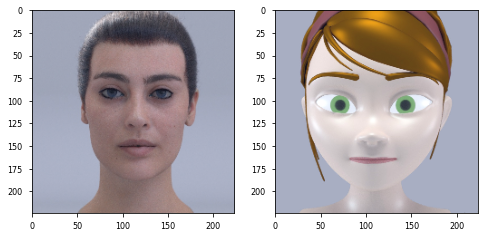

In [19]:
# plot the pre-processed images to see how the training data looks like
plt.figure(figsize=(4*n_training, 4))
for i in range(n_training):
    plt.subplot(1, n_training, i + 1)
    img = np.array(data[0][i])
    rgb_img = img[..., ::-1]
    norm_img = (rgb_img + 127.5) / 256
    plt.imshow(norm_img)

## Predict with extraction pipeline

In [20]:
def predict_v4(data):
    # predict v4 output
    preds = v4_model.predict(data[0], verbose=1)
    print("[TRAIN] shape prediction", np.shape(preds))

    # get feature maps that mimic a semantic selection pipeline
    # keep only highest IoU semantic score
    eyebrow_preds = preds[..., config['best_eyebrow_IoU_ft']]
    print("shape eyebrow semantic feature selection", np.shape(eyebrow_preds))
    lips_preds = preds[..., config['best_lips_IoU_ft']]
    print("shape lips semantic feature selection", np.shape(lips_preds))
    preds = np.concatenate((eyebrow_preds, lips_preds), axis=3)
    print("[TRAIN] shape preds", np.shape(preds))

    return preds

In [21]:
preds = predict_v4(data)

1/1 [==============================] - 0s 57ms/step
[TRAIN] shape prediction (2, 56, 56, 256)
shape eyebrow semantic feature selection (2, 56, 56, 2)
shape lips semantic feature selection (2, 56, 56, 16)
[TRAIN] shape preds (2, 56, 56, 18)


2022-07-04 11:18:45.527500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


## Train and detect facial identity (Facial Recognition)

### Build RBF templates

In [22]:
def get_templates(preds, sigmas, rbfs, masks=None, zeros=None, verbose=False):
    # create FR templates
    templates = []
    rbf_templates = []
    patterns = []

    for i in range(len(preds)):
        config['rbf_sigma'] = config[sigmas[i]]
        rbf_template = np.array(config[rbfs[i]])

        mask = None
        zero = None
        if masks is not None:
            mask = np.array(config[masks[i]])
        if zero is not None:
            zero = np.array(config[zeros[i]])

        pattern = PatternFeatureSelection(config, template=rbf_template, mask=mask, zeros=zero)

        # fit template
        neutral_preds = np.expand_dims(preds[i], axis=0)
        template_preds = np.repeat(np.expand_dims(neutral_preds, axis=0), len(rbf_template), axis=0)
        template = pattern.fit(template_preds)
        template[template < 0.25] = 0

        templates.append(template[0])
        rbf_templates.append(rbf_template)
        patterns.append(pattern)

    templates = np.array(templates)

    if verbose:
        print("[RBF] shape templates", np.shape(templates))
        print("[RBF] Shape rbf_templates", np.shape(rbf_templates))

    return templates,  rbf_templates, patterns

In [23]:
sigmas = ['louise_rbf_FR_sigma', 'merry_rbf_FR_sigma']
rbfs = ['louise_rbf_FR_pos', 'merry_rbf_FR_pos']
fr_templates,  rbf_fr_templates, fr_patterns = get_templates(preds, sigmas, rbfs, verbose=True)

[PATTERN] Fit pattern
[PATTERN] Fit pattern
[RBF] shape templates (2, 56, 56, 3)
[RBF] Shape rbf_templates (2, 3, 2, 2)


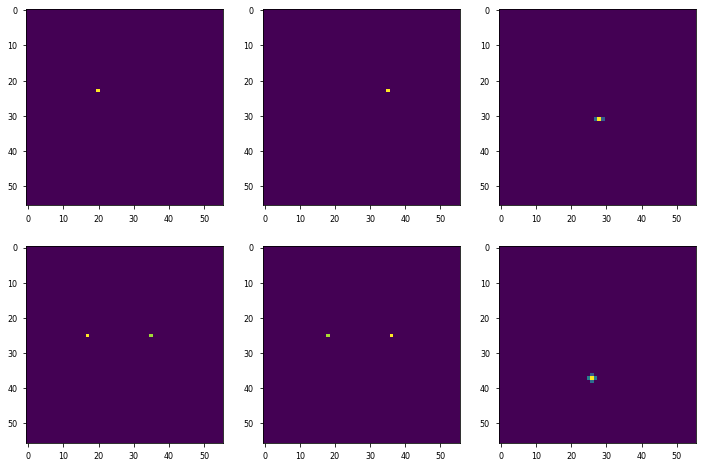

In [24]:
# show templates
n_templates = np.shape(fr_templates)[-1]

plt.figure(figsize=(n_templates * 4, n_training * 4))
for i in range(n_training):
    for j in range(n_templates):
        plt.subplot(n_training, n_templates, i * n_templates + j + 1)
        plt.imshow(fr_templates[i, ..., j])

### patch images (Transformers trick)

In [25]:
# split in patches
def pred_to_patch(pred, patch_size=8):
    pred = np.expand_dims(pred, axis=[0, 3])
    patches = tf.image.extract_patches(
        images=pred,
        sizes=[1, patch_size, patch_size, 1],
        strides=[1, patch_size, patch_size, 1],
        rates=[1, 1, 1, 1],
        padding="VALID",
    )
    patches = patches.numpy()
    return patches

In [26]:
def get_patches_centers(patches, patch_size=8, verbose=False):
    # compute center of activity for each patch
    centers = []
    max_patch = []
    for i in range(np.shape(patches)[1]):
        for j in range(np.shape(patches)[2]):
            # control if patches is not all zeros
            f_patch = patches[0, i, j]
            if np.sum(f_patch) > 0:
                CoA = compute_center_of_activity(np.reshape(f_patch, [patch_size, patch_size]), verbose=verbose)
                # compensate with patch positions
                centers.append([CoA[0] + j*patch_size, CoA[1] + i*patch_size])

                # keep maximum activity of the patch
                max_patch.append(np.amax(f_patch))

    return centers, max_patch

In [27]:
def get_activity_from_patterns(preds, patterns, rbf_templates, threshold_val=0.1, face_pos_offset=None, face_x_scales=None, verbose=False, do_plot=False):
    templates = []
    for p, pattern in enumerate(patterns):
        _preds = np.expand_dims(preds, axis=0)
        _preds = np.repeat(np.expand_dims(_preds, axis=0), len(rbf_templates[p]), axis=0)
        template = pattern.transform(_preds, face_x_scales=face_x_scales)

        if verbose:
            print("[Pattern] max value found on pattern {}: {}".format(p, np.max(template, axis=(0, 1, 2))))

        # apply threshold
        template[template < threshold_val] = 0
        templates.append(template)

        if do_plot:
            n_templates = np.shape(template)[-1]
            plt.figure(figsize=(n_templates * 4, 4))
            for i in range(n_templates):
                plt.subplot(1, n_templates, i+1)
                plt.imshow(template[0, ..., i], cmap='Greys')
                plt.title("Activity template {}".format(i))

    # concatenate all templates
    _templates = np.array(templates[0])
    for i in range(1, len(patterns)):
        _templates = np.concatenate((_templates, templates[i]), axis=3)

    # get pos for each type
    pos_dict = {}
    n_entry = 0
    for i in range(np.shape(_templates)[-1]):
        patches = pred_to_patch(_templates[0, ..., i])
        positions, max_values = get_patches_centers(patches)

        for pos, max_val in zip(positions, max_values):
            pos_dict[n_entry] = {'type': i, 'pos': pos, 'max': max_val}
            n_entry += 1

    return pos_dict

In [28]:
def get_lmk(preds, fr_patterns, rbf_fr_templates, face_x_scales=None, verbose=False, do_plot=False):
    # compute fr lmk activity
    fr_lmks = []
    for i in range(np.shape(preds)[0]):
        fr_lmk = get_activity_from_patterns(preds[i], fr_patterns, rbf_fr_templates, face_x_scales=face_x_scales, verbose=verbose, do_plot=do_plot)
        fr_lmks.append(fr_lmk)

        if verbose:
            for j in range(len(fr_lmk)):
                print("[LMK] {}) {}".format(j, fr_lmk[j]))
            print()

    return fr_lmks

In [29]:
fr_lmks = get_lmk(preds, fr_patterns, rbf_fr_templates, verbose=True)

[Pattern] max value found on pattern 0: [1. 1. 1.]
[Pattern] max value found on pattern 1: [0.    0.002 0.151]
[LMK] 0) {'type': 0, 'pos': [19.964229668931033, 22.999964689542665], 'max': 1.0}
[LMK] 1) {'type': 0, 'pos': [34.4448689883922, 22.999808866681434], 'max': 0.13009871720332733}
[LMK] 2) {'type': 1, 'pos': [19.999754536874686, 22.9995704395307], 'max': 0.10428625074867053}
[LMK] 3) {'type': 1, 'pos': [34.98583391691482, 22.999964548314228], 'max': 1.0}
[LMK] 4) {'type': 2, 'pos': [16.999971535416623, 8.445234550644557], 'max': 0.12472751333507053}
[LMK] 5) {'type': 2, 'pos': [29.395987806715258, 17.999960601732525], 'max': 0.11563790665865996}
[LMK] 6) {'type': 2, 'pos': [27.810070229077503, 30.86049485703583], 'max': 1.0}
[LMK] 7) {'type': 2, 'pos': [32.0, 30.99962910725839], 'max': 0.12078323801069583}
[LMK] 8) {'type': 2, 'pos': [27.44515952169158, 45.76491990699725], 'max': 0.1680293659991795}
[LMK] 9) {'type': 5, 'pos': [27.369397873031883, 46.39144042956993], 'max': 0.12

#### Helper to fine-tune sigma of FR LMK

In [49]:
# # fine tune FR lmks
# config['louise_rbf_FR_sigma'] = [1600, 1600, 1600]
# config['merry_rbf_FR_sigma'] = [1600, 1600, 1600]
# fr_templates,  rbf_fr_templates, fr_patterns = get_templates(preds, sigmas, rbfs, verbose=True)
# fr_lmks = get_lmk(preds, fr_patterns, rbf_fr_templates, verbose=True)

### Get identity (Max pooling)

In [42]:
def max_pool_activity(activity_dict, dist_threshold=2, sorting='max', verbose=False):
    filt_dictionary = {}
    discarded_primer_idx = []

    for p_t in range(len(activity_dict)):
        for p_a in range(p_t + 1, len(activity_dict)):  # only upward diagonal
            # get primers
            p_target = activity_dict[p_t]
            p_agent = activity_dict[p_a]

            # retrieve positions
            pos_target = np.array(p_target["pos"])
            pos_agent = np.array(p_agent["pos"])
            distance = np.linalg.norm(pos_target - pos_agent)

            if verbose:
                print("distance between {} ({}-{}) and {} ({}-{}): {}".format(p_t, p_target["type"], p_target["max"], p_a, p_agent["type"], p_agent["max"], distance))

            # sort if distance is smaller than the threshold
            if distance < dist_threshold:
                # todo add possibility to sort by clustering the mean
                if sorting == 'max':
                    if p_target["max"] >= p_agent["max"]:
                        discarded_primer_idx.append(p_a)
                        if verbose:
                            print("discarded agent primer", p_a)
                    else:
                        discarded_primer_idx.append(p_t)
                        if verbose:
                            print("discarded target primer", p_t)

    if verbose:
        print("discarded primers")
        print(discarded_primer_idx)

    # append all non discarded primers
    n_primer = 0
    for p in activity_dict:
        if p not in discarded_primer_idx:
            primer = activity_dict[p]
            filt_dictionary[n_primer] = {"type": primer["type"], "pos": primer["pos"], "max": primer["max"]}
            n_primer += 1

    return filt_dictionary

In [43]:
def max_pool_lmks(fr_lmks, verbose=False):
    # pool fr lmks (max activation)
    fr_lmks_pooled = []
    for i in range(np.shape(fr_lmks)[0]):
        fr_lmk_pooled = max_pool_activity(fr_lmks[i], verbose=verbose)
        fr_lmks_pooled.append(fr_lmk_pooled)

        if verbose:
            print("[FR] len fr_lmk_pooled", len(fr_lmk_pooled))
            for j in range(len(fr_lmk_pooled)):
                print("[FR LMK] {}) fer_lmk: {}".format(j, fr_lmk_pooled[j]))
            print()
    return fr_lmks_pooled

In [44]:
fr_lmks_pooled = max_pool_lmks(fr_lmks, verbose=True)

distance between 0 (0-1.0) and 1 (1-1.0): 15.000006399959037
distance between 0 (0-1.0) and 2 (2-1.0): 11.281924568796931
distance between 1 (1-1.0) and 2 (2-1.0): 10.659860991364845
discarded primers
[]
[FR] len fr_lmk_pooled 3
[FR LMK] 0) fer_lmk: {'type': 0, 'pos': [19.99997440016384, 22.999955200286717], 'max': 1.0}
[FR LMK] 1) fer_lmk: {'type': 1, 'pos': [34.99998080012288, 22.999955200286717], 'max': 1.0}
[FR LMK] 2) fer_lmk: {'type': 2, 'pos': [27.954950260049664, 30.999966515569817], 'max': 1.0}

distance between 0 (3-1.0) and 1 (3-0.5780663265099243): 17.999973186145674
distance between 0 (3-1.0) and 2 (4-0.62106394939904): 0.999985790385139
discarded agent primer 2
distance between 0 (3-1.0) and 3 (4-1.0): 18.999980800122877
distance between 0 (3-1.0) and 4 (5-1.0): 15.019915280890704
distance between 1 (3-0.5780663265099243) and 2 (4-0.62106394939904): 16.999987395767572
distance between 1 (3-0.5780663265099243) and 3 (4-1.0): 1.000007613988718
discarded target primer 1
dist

### Classification of Facial Identities Recognition

In [45]:
def get_type(activity_dict, verbose=False):
    # declare variables
    type_counters = [0, 0, 0]
    positions = []
    right_eye_pos = None
    left_eye_pos = None
    nose_pos = None

    for i in activity_dict:
        if verbose:
            print("activity dict:", activity_dict[i])
        dict = activity_dict[i]

        # count types
        if dict['type'] in [0, 1, 2]:
            type_counters[0] += 1
        elif dict['type'] in [3, 4, 5]:
            type_counters[1] += 1
        elif dict['type'] in [6, 7, 8]:
            type_counters[2] += 1

        # get positions of types
        if dict['type'] in [0, 3, 6]:
            right_eye_pos = dict['pos']
        elif dict['type'] in [1, 4, 7]:
            left_eye_pos = dict['pos']
        elif dict['type'] in [2, 5, 8]:
            nose_pos = dict['pos']
        else:
            print("dict type ({}) not found!".format(dict['type']))

        positions.append(dict['pos'])

    if verbose:
        print("types:", type_counters)
        print("positions")
        print(positions)

    bfs_type = np.argmax(type_counters)
    if len(positions) != 0:
        mean_pos = np.mean(positions, axis=0)
    else:
        print("No landmarks have been found! Please re-consider your threshold value")
        mean_pos = None

    if left_eye_pos and right_eye_pos is not None:
        width = left_eye_pos[0] - right_eye_pos[0]
    else:
        width = None

    if nose_pos and left_eye_pos and right_eye_pos is not None:
        height = nose_pos[1] - np.amin([left_eye_pos[1], right_eye_pos[1]])
    else:
        height = None

    return bfs_type, mean_pos, [width, height]

In [46]:
def get_face_pos_scales(lmks_pooled, verbose=False):
    face_types = []
    face_poses = []
    face_sizes = []
    for i in range(np.shape(lmks_pooled)[0]):
        face_type, face_pos, face_size = get_type(lmks_pooled[i], verbose=verbose)
        face_types.append(face_type)
        face_poses.append(face_pos)
        face_sizes.append(face_size)

        if verbose:
            print("Face type:", face_type)
            print("Face pos:", face_pos)
            print("face size:", face_size)
            print()

    return face_types, face_poses, face_sizes

In [47]:
fr_face_types, fr_face_poses, fr_face_sizes = get_face_pos_scales(fr_lmks_pooled, verbose=True)
print("fr_face_types:", fr_face_types)
print("fr_face_poses:", fr_face_poses)
print("fr_face_sizes:", fr_face_sizes)

activity dict: {'type': 0, 'pos': [19.99997440016384, 22.999955200286717], 'max': 1.0}
activity dict: {'type': 1, 'pos': [34.99998080012288, 22.999955200286717], 'max': 1.0}
activity dict: {'type': 2, 'pos': [27.954950260049664, 30.999966515569817], 'max': 1.0}
types: [3, 0, 0]
positions
[[19.99997440016384, 22.999955200286717], [34.99998080012288, 22.999955200286717], [27.954950260049664, 30.999966515569817]]
Face type: 0
Face pos: [27.652 25.667]
face size: [15.000006399959037, 8.0000113152831]

activity dict: {'type': 3, 'pos': [16.99999360004096, 24.99999360004096], 'max': 1.0}
activity dict: {'type': 4, 'pos': [35.999974400163836, 24.99999360004096], 'max': 1.0}
activity dict: {'type': 5, 'pos': [25.992923628152532, 37.03016668917909], 'max': 1.0}
types: [0, 3, 0]
positions
[[16.99999360004096, 24.99999360004096], [35.999974400163836, 24.99999360004096], [25.992923628152532, 37.03016668917909]]
Face type: 1
Face pos: [26.331 29.01 ]
face size: [18.999980800122877, 12.0301730891381

In [48]:
# save reference to face scale to compute x_scales
ref_face_x_scale = np.array(fr_face_sizes)[:, 0]

x_scales = []
for i in range(n_training):
    type = fr_face_types[i]
    x_scales.append(fr_face_sizes[i][0] / ref_face_x_scale[i])

print("x_scales:", x_scales)

x_scales: [1.0, 1.0]


In [50]:
def draw_lmks_on_images(data, lmks):
    # display FR lmks on training img
    img_to_ft_ratio = 224 / 56

    n_images = len(data[0])
    plt.figure(figsize=(4 * n_images, 4))
    plt.suptitle("Landmarks for Facial Recognition on Neutral Pose")
    for i in range(n_images):
        plt.subplot(1, n_images, i + 1)
        img = np.array(data[0][i])
        img = img[..., ::-1]
        img = (np.array(img) + 127.5) / 256

        lmk = lmks[i]
        n_lmk = len(lmk)
        for j in range(n_lmk):
            lmk_pos = np.array(lmk[j]['pos']) * img_to_ft_ratio
            pos_x = int(round(lmk_pos[0]))
            pos_y = int(round(lmk_pos[1]))
            img[(pos_y-1):(pos_y+1), (pos_x-1):(pos_x+1)] = [1, 0, 0]

        plt.imshow(img)
        # plt.imsave("test_0.jpg", img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


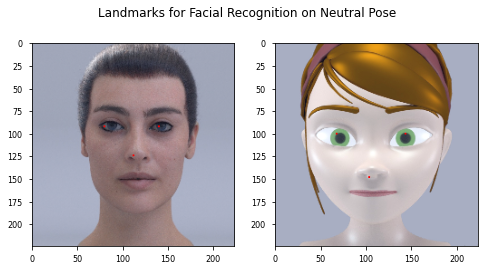

In [51]:
draw_lmks_on_images(data, fr_lmks_pooled)

## FER recognition

In [52]:
ref_sigmas = ['louise_rbf_FER_sigma', 'merry_rbf_FER_sigma']
ref_rbfs = ['louise_rbf_FER_pos', 'merry_rbf_FER_pos']
ref_rbfs_mask = ['louise_rbf_FER_mask', 'merry_rbf_FER_mask']
ref_rbfs_zeros = ['louise_rbf_FER_zeros', 'merry_rbf_FER_zeros']

fer_templates,  rbf_fer_templates, fer_patterns = get_templates(preds,
                                                                ref_sigmas,
                                                                ref_rbfs,
                                                                ref_rbfs_mask,
                                                                ref_rbfs_zeros,
                                                                verbose=True)

[PATTERN] Fit pattern
[PATTERN] fit pattern: use mask ON
[PATTERN] Fit pattern
[PATTERN] fit pattern: use mask ON
[RBF] shape templates (2, 56, 56, 10)
[RBF] Shape rbf_templates (2, 10, 2, 2)


shape fer_templates (2, 56, 56, 10)


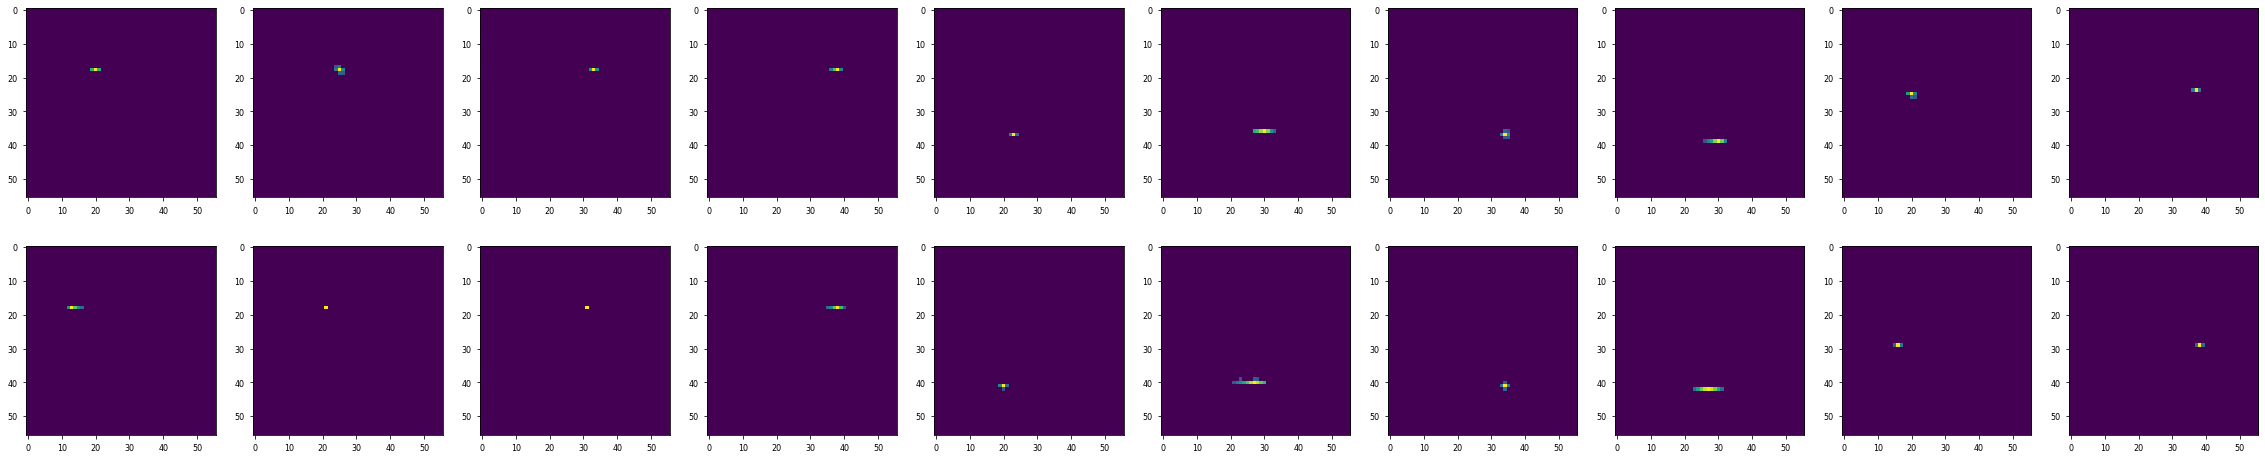

In [53]:
# show fer templates
print("shape fer_templates", np.shape(fer_templates))
n_templates = np.shape(fer_templates)[-1]

plt.figure(figsize=(n_templates * 4, n_training * 4))
for i in range(n_training):
    for j in range(n_templates):
        plt.subplot(n_training, n_templates, i * n_templates + j + 1)
        plt.imshow(fer_templates[i, ..., j])

In [54]:
# compute fer lmk activity
fer_lmks = []
for i in range(n_training):
    fer_lmk = get_activity_from_patterns(preds[i], fer_patterns, rbf_fer_templates, face_x_scales=x_scales)
    fer_lmks.append(fer_lmk)

    for j in range(len(fer_lmk)):
        print("[FER LMK] {}) fer_lmk: {}".format(j, fer_lmk[j]))
    print()

[FER LMK] 0) fer_lmk: {'type': 0, 'pos': [20.067551341307045, 17.999995075793652], 'max': 1.0}
[FER LMK] 1) fer_lmk: {'type': 1, 'pos': [25.24127010307621, 18.04238961891689], 'max': 1.0}
[FER LMK] 2) fer_lmk: {'type': 2, 'pos': [30.999830088537, 18.515852977035674], 'max': 0.13602606810496345}
[FER LMK] 3) fer_lmk: {'type': 2, 'pos': [33.29234703609794, 17.900729782423443], 'max': 1.0}
[FER LMK] 4) fer_lmk: {'type': 3, 'pos': [37.2501660628668, 17.892962795058267], 'max': 1.0}
[FER LMK] 5) fer_lmk: {'type': 4, 'pos': [22.548771448138243, 36.979564895725154], 'max': 1.0}
[FER LMK] 6) fer_lmk: {'type': 4, 'pos': [24.0, 36.99991061298244], 'max': 0.3579874214053882}
[FER LMK] 7) fer_lmk: {'type': 4, 'pos': [24.999937691338683, 40.0], 'max': 0.10270805196789842}
[FER LMK] 8) fer_lmk: {'type': 5, 'pos': [29.06437624872386, 35.92271022036606], 'max': 1.0}
[FER LMK] 9) fer_lmk: {'type': 5, 'pos': [32.3819640668649, 35.99997029608631], 'max': 0.5326412521471958}
[FER LMK] 10) fer_lmk: {'type'

In [55]:
# pool fer lmks (max activation)
fer_lmks_pooled = []
for i in range(n_training):
    fer_lmk_pooled = max_pool_activity(fer_lmks[i], verbose=True)
    fer_lmks_pooled.append(fer_lmk_pooled)

    print("[FER] len fer_lmk_pooled", len(fer_lmk_pooled))
    for j in range(len(fer_lmk_pooled)):
        print("[FER LMK] {}) fer_lmk: {}".format(j, fer_lmk_pooled[j]))
    print()
print("len fer_lmks_pooled", len(fer_lmks_pooled))

distance between 0 (0-1.0) and 1 (1-1.0): 5.173892453769106
distance between 0 (0-1.0) and 2 (2-0.13602606810496345): 10.944442789900707
distance between 0 (0-1.0) and 3 (2-1.0): 13.225168232103044
distance between 0 (0-1.0) and 4 (3-1.0): 17.182948075888536
distance between 0 (0-1.0) and 5 (4-1.0): 19.141069034100425
distance between 0 (0-1.0) and 6 (4-0.3579874214053882): 19.402601446032023
distance between 0 (0-1.0) and 7 (4-0.10270805196789842): 22.546144942563508
distance between 0 (0-1.0) and 8 (5-1.0): 20.054091267574325
distance between 0 (0-1.0) and 9 (5-0.5326412521471958): 21.809261076582374
distance between 0 (0-1.0) and 10 (6-1.0): 23.307175559144834
distance between 0 (0-1.0) and 11 (6-0.15583004034620046): 25.715614060966264
distance between 0 (0-1.0) and 12 (7-1.0): 22.85841353468117
distance between 0 (0-1.0) and 13 (7-0.42703550976291027): 24.44324171088968
distance between 0 (0-1.0) and 14 (7-0.17665267968004594): 23.955472093601312
distance between 0 (0-1.0) and 15 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


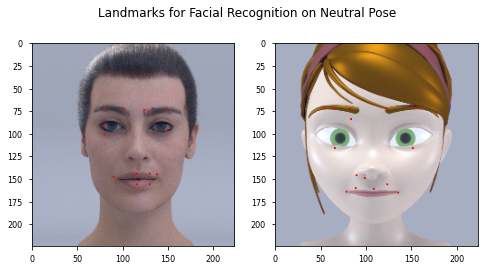

In [56]:
# plot landmarks on images
draw_lmks_on_images(data, fer_lmks_pooled)

# Train Norm-referenced encoding

### get training set on Louise

In [33]:
# load the training data to train ref and tuning vectors: Louise all expressions
config['train_avatar'] = 'Louise'
config['train_expression'] = ['full']
data = load_data(config)
n_training = len(data[0])
print("[LOAD] Training Data loaded", np.shape(data[0]))
print("[LOAD] Labels Data loaded", np.shape(data[1]))
print()

/Users/michaelstettler/PycharmProjects/BVS/BVS/utils/load_data.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(sub_df, ignore_index=True)
100%|██████████| 7/7 [00:00<00:00, 169.14it/s]

[LOAD] Training Data loaded (7, 224, 224, 3)
[LOAD] Labels Data loaded (7,)



In [34]:
def compute_face_pos_and_scales(types, faces_pos, faces_size, verbose=False):
    x_pos_offset = []
    x_scales_offset = []

    for i in range(len(types)):
        type = types[i]

        try:
            x_scales_offset.append(faces_size[i][0] / ref_face_x_scale[type])
        except:
            print("Not able to compute the scale offset for: {}. Set to 1.0".format(faces_size[i][0]))
            x_scales_offset.append(1.0)

    if verbose:
        print("x_scales_offset:", x_scales_offset)
    print("TODO face pos!")

    return x_pos_offset, x_scales_offset

In [35]:
def predict_fer_lmk_pos(data, verbose=False):
    # get preds from VGG
    preds = predict_v4(data)

    # get Facial Recognition landmarks
    fr_lmks = get_lmk(preds, fr_patterns, rbf_fr_templates, verbose=False)
    fr_lmks_pooled = max_pool_lmks(fr_lmks)

    # get face types and pos
    fr_types, fr_faces_pos, fr_faces_size = get_face_pos_scales(fr_lmks_pooled, verbose=False)
    print("fr_types", fr_types)
    print("fr_faces_pos", fr_faces_pos)
    print("fr_faces_size", fr_faces_size)

    # get offset for face pos and scales
    x_pos_offset, face_x_scales = compute_face_pos_and_scales(fr_types, fr_faces_pos, fr_faces_size, verbose=verbose)
    print("x_pos_offset", x_pos_offset)
    print("face_x_scales", face_x_scales)

    # get Facial Expression landmarks
    fer_lmks = get_lmk(preds, fer_patterns, rbf_fer_templates, face_x_scales=face_x_scales)
    fer_lmks_pooled = max_pool_lmks(fer_lmks)
    print("shape fer_lmks_pooled", np.shape(fer_lmks_pooled))

    return fer_lmks_pooled

In [36]:
fer_preds = predict_fer_lmk_pos(data, verbose=True)
print("fer_preds:", len(fer_preds))
for i in range(len(fer_preds)):
    for j in range(len(fer_preds[i])):
        print("lmk:", fer_preds[i][j])
    print()

1/1 [==============================] - 0s 30ms/step
[TRAIN] shape prediction (7, 56, 56, 256)
shape eyebrow semantic feature selection (7, 56, 56, 2)
shape lips semantic feature selection (7, 56, 56, 16)
[TRAIN] shape preds (7, 56, 56, 18)
No landmarks have been found! Please re-consider your threshold value
No landmarks have been found! Please re-consider your threshold value
fr_types [0, 0, 0, 0, 0, 0, 0]
fr_faces_pos [array([27.467, 25.667]), array([27.807, 25.667]), None, array([28., 31.]), array([27.667, 25.667]), array([27.505, 25.667]), None]
fr_faces_size [[15.010209153601132, 7.999986785300688], [15.421499371144932, 7.9999550604492775], [None, None], [None, None], [15.000006245836104, 8.000032459243634], [15.000014587326682, 8.000032938804924], [None, None]]
Not able to compute the scale offset for: None. Set to 1.0
Not able to compute the scale offset for: None. Set to 1.0
Not able to compute the scale offset for: None. Set to 1.0
x_scales_offset: [1.0, 1.0274006986401736, 1.

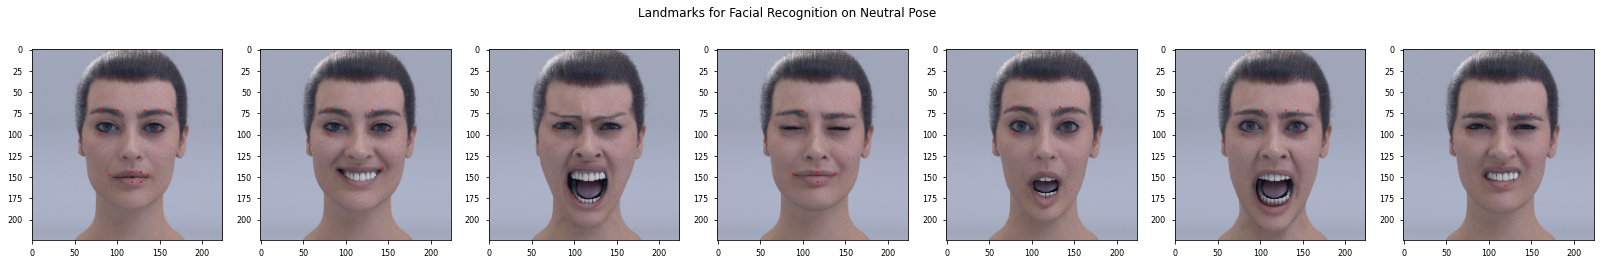

In [43]:
#plot landmarks on images
draw_lmks_on_images(data, fer_preds)

### Train Norm-reference Model

In [37]:
def get_pos_data_from_dict(lmks):
    positions = []
    for i in range(len(lmks)):
        lmk_dict = lmks[i]
        pos = [lmk_dict[j]["pos"] for j in lmk_dict]
        pos = np.reshape(pos, -1)
        positions.append(pos)
    return np.array(positions)

In [42]:
# get lmks pos to learn reference
pos = get_pos_data_from_dict(fer_preds)
print("[NRE Training] shape pos", np.shape(pos))

# declare a model to access its functions and train it
nre_model = NormBase(config, tuple(config['input_shape']))
nre_model.n_features = np.shape(pos)[-1]
nre_model.r = np.zeros(nre_model.n_features)  # need to reset the size since initial set it to the size of VGG
# train manually ref vector
nre_model._fit_reference([pos, data[1]], config['batch_size'])
print("[TRAIN] model.r", np.shape(nre_model.r))
ref_train = np.copy(nre_model.r)
# train manually tuning vector
nre_model.t = np.zeros((nre_model.n_category, nre_model.n_features))
nre_model.t_mean = np.zeros((nre_model.n_category, nre_model.n_features))
nre_model._fit_tuning([pos, data[1]], config['batch_size'])
ref_tuning = np.copy(nre_model.t)
# get it resp
it_train = nre_model._get_it_resp(pos)
print("[TRAIN] shape it_train", np.shape(it_train))
print(it_train)

/var/folders/lf/lmvw46z53hb8fjgs_pnwkz0m0000gn/T/ipykernel_47024/3683463645.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(positions)


[NRE Training] shape pos (7,)
nu missing from json configuration file! Set to '2.0'
tuning_function missing from json configuration file! Set to '2-norm'
1 Physical GPUs, 1 Logical GPUs

[INIT] -- Model loaded --
[INIT] Extraction Model: VGG19
[INIT] V4 layer: block3_conv3
[INIT] shape_v4 (None, 56, 56, 256)
[INIT] n_features: 802816
[INIT] Neutral threshold (2.0%): 16056.32

[FIT] Learning reference pattern


  0%|          | 0/1 [00:00<?, ?it/s]


ValueError: operands could not be broadcast together with shapes (7,) (24,) 